In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Set the font family to Tahoma
plt.rcParams['font.family'] = 'Tahoma'

In [3]:
# Dictionary to map Thai month abbreviations to month numbers
thai_months = {
    "ม.ค.": 1,
    "ก.พ.": 2,
    "มี.ค.": 3,
    "เม.ย.": 4,
    "พ.ค.": 5,
    "มิ.ย.": 6,
    "ก.ค.": 7,
    "ส.ค.": 8,
    "ก.ย.": 9,
    "ต.ค.": 10,
    "พ.ย.": 11,
    "ธ.ค.": 12
}

def convert_thai_date(thai_date):
    # Split the input string
    thai_month_abbr, buddhist_year = thai_date.split("-")
    
    # Convert the Thai month abbreviation to a month number
    month = thai_months[thai_month_abbr.strip()]
    
    # Convert the Buddhist year to Gregorian year
    year = int(buddhist_year.strip())
    if year >= 75:
        year += 1900
    else:
        year += 2000
    # Use the first day of the month for the conversion
    day = 1
    
    # Create a datetime object
    date = datetime(year, month, day)
    
    # Return the formatted date in "Y-M-d" format
    return date.strftime("%Y-%m-%d")

In [4]:
df = pd.read_csv('./Table_PBV.csv', skiprows=3)
df['SET'] = df['SET'].str.replace(',', '')

set_index = pd.read_csv('./Table_Index.csv', skiprows=3)
set_index['SET'] = set_index['SET'].str.replace(',', '')

In [5]:
# set_index['Month-Year'].head(50)

In [6]:
df['SET'] = pd.to_numeric(df['SET'], errors='coerce')
set_index['SET'] = pd.to_numeric(set_index['SET'], errors='coerce')

In [7]:
selected_df = df[['Month-Year', 'SET']].dropna(axis=0)[::-1].copy()
set_index = set_index[['Month-Year', 'SET']].dropna(axis=0)[::-1].copy()

In [8]:
selected_df['Month-Year'] = selected_df['Month-Year'].apply(convert_thai_date)
selected_df['Month-Year'] = pd.to_datetime(selected_df['Month-Year'])

set_index['Month-Year'] = set_index['Month-Year'].apply(convert_thai_date)
set_index['Month-Year'] = pd.to_datetime(set_index['Month-Year'])

In [9]:
selected_df.set_index('Month-Year', inplace=True)
set_index.set_index('Month-Year', inplace=True)

In [10]:
selected_df['set-index'] = set_index

In [11]:
selected_df

,SET,set-index
Month-Year,,
1988-04-01,3.07,413.91
1988-05-01,3.16,424.93
1988-06-01,3.52,452.70
1988-07-01,3.51,457.01
1988-08-01,3.33,436.55
...,...,...
2024-02-01,1.33,1370.67
2024-03-01,1.33,1377.94
2024-04-01,1.32,1367.95


In [12]:
selected_df['log-SET'] = np.log(selected_df['SET'])

In [13]:
# selected_df['SET'][::-1].cumprod()** (1 / np.arange(1, len(selected_df)+1))
selected_df['gmean-SET'] = np.exp(selected_df['log-SET'].cumsum() / np.arange(1, len(selected_df)+1))

In [14]:
selected_df['scaled-SET'] = selected_df['SET'] / selected_df['gmean-SET'].shift()

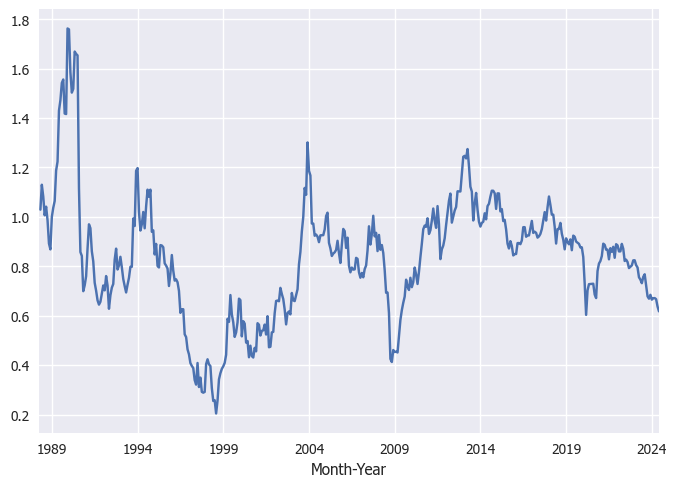

In [15]:
selected_df['scaled-SET'].plot();

In [16]:
n = 4
selected_df['quarter'], bins = pd.qcut(selected_df['scaled-SET'], q=n, labels=False, retbins=True)

In [17]:
bins

array([0.20427023, 0.68825346, 0.85390345, 0.96067702, 1.76269296])

In [18]:
selected_df['ret'] = selected_df['set-index'].pct_change()

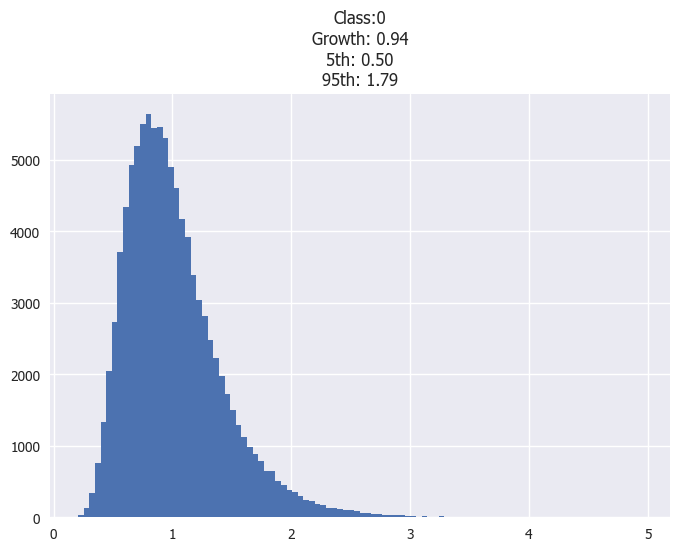

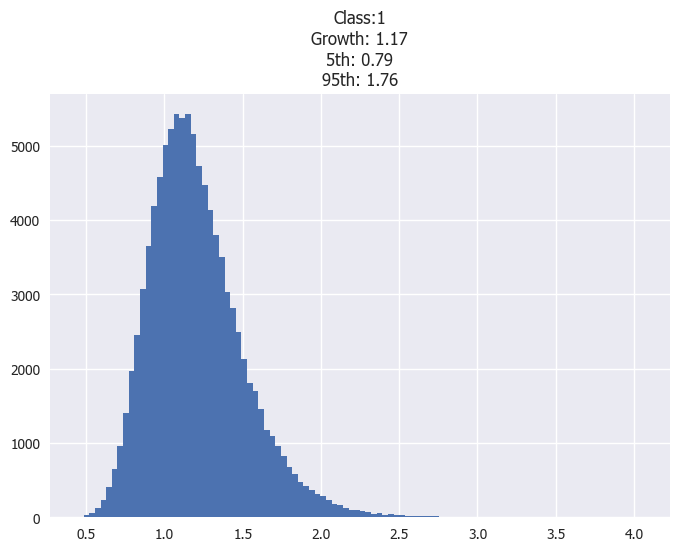

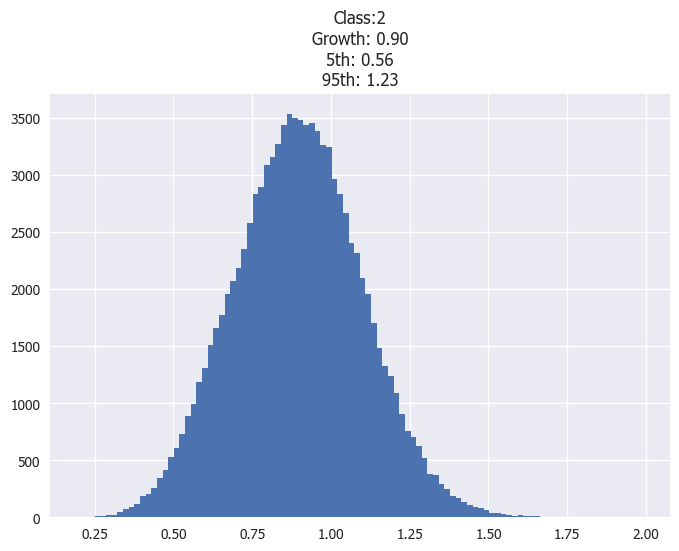

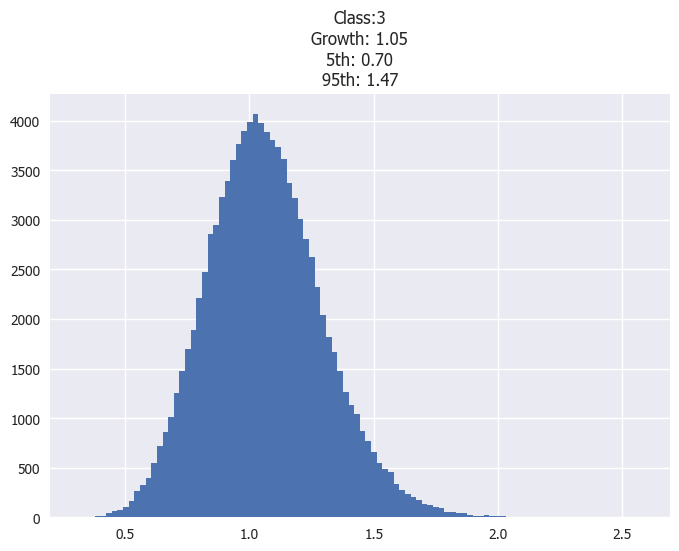

In [19]:
m = 100000
d = 12

for i in range(n):
    years_to_filter  = selected_df[
        (selected_df.index.month == 1) & (selected_df['quarter'] == i)
        ].index.year
    mask = selected_df.index.year.isin(years_to_filter)
    
    bootstrapping_sample = np.random.choice(selected_df[mask]['ret'], size=(m, d), replace=True) + 1
    
    ret_rest = np.prod(bootstrapping_sample, axis=1)
    
    plt.hist(ret_rest, bins=100)
    plt.title(f'Class:{i}\nGrowth: {np.median(ret_rest):.2f}\n5th: {np.quantile(ret_rest, 0.05):.2f}\n95th: {np.quantile(ret_rest, 0.95):.2f}')
    plt.show()

In [20]:
selected_df

,SET,set-index,log-SET,gmean-SET,scaled-SET,quarter,ret
Month-Year,,,,,,,
1988-04-01,3.07,413.91,1.121678,3.070000,NaN,NaN,NaN
1988-05-01,3.16,424.93,1.150572,3.114675,1.029316,3.0,0.026624
1988-06-01,3.52,452.70,1.258461,3.244313,1.130134,3.0,0.065352
1988-07-01,3.51,457.01,1.255616,3.308787,1.081893,3.0,0.009521
1988-08-01,3.33,436.55,1.202972,3.313019,1.006411,3.0,-0.044769
...,...,...,...,...,...,...,...
2024-02-01,1.33,1370.67,0.285179,1.980977,0.670764,0.0,0.004507
2024-03-01,1.33,1377.94,0.285179,1.979151,0.671386,0.0,0.005304
2024-04-01,1.32,1367.95,0.277632,1.977301,0.666953,0.0,-0.007250


In [21]:
years_to_filter  = selected_df[
        (selected_df.index.month == 1) & (selected_df['quarter'] == 1)
        ].index.year
mask = selected_df.index.year.isin(years_to_filter)

In [24]:
selected_df[mask].tail(24)

,SET,set-index,log-SET,gmean-SET,scaled-SET,quarter,ret
Month-Year,,,,,,,
2021-01-01,1.66,1466.98,0.506818,2.019864,0.821427,1.0,0.012164
2021-02-01,1.70,1496.78,0.530628,2.018983,0.841641,1.0,0.020314
2021-03-01,1.80,1587.21,0.587787,2.018398,0.891538,2.0,0.060416
2021-04-01,1.79,1583.13,0.582216,2.017787,0.886842,2.0,-0.002571
2021-05-01,1.75,1593.59,0.559616,2.017065,0.867287,2.0,0.006607
2021-06-01,1.75,1587.79,0.559616,2.016348,0.867597,2.0,-0.003640
2021-07-01,1.67,1521.92,0.512824,2.015398,0.828230,1.0,-0.041485
2021-08-01,1.76,1638.75,0.565314,2.014717,0.873277,2.0,0.076765
2021-09-01,1.73,1605.68,0.548121,2.013953,0.858681,2.0,-0.020180
